In [44]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture    
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,mean_squared_error
from sklearn.preprocessing import LabelEncoder, FunctionTransformer,StandardScaler,MinMaxScaler,RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline  
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.compose import ColumnTransformer 
from scipy.stats import kurtosis, zscore 


from sklearn.manifold import TSNE



In [45]:
import random 
random.seed(42) 
plt.rcParams.update({'font.size': 12})

In [46]:
#Loading Dataset for CSV 
spotify_df=pd.read_csv('spotify-2023.csv', encoding='ISO-8859-1')
marketing_df=pd.read_csv("marketing_campaign.csv",sep="\t") 

Below This put pre proccessing

In [47]:
#Marketing Campaign 
# Creating are "target class"
marketing_df['AcceptedAny'] = (marketing_df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',"Response"]].sum(axis=1) > 0).astype(int)

# One hot encoding marital status
relationship_dict = {
    'Single': 0,
    'Together': 1,
    'Married': 1,
    'Divorced':0,
    'Widow': 0,
    'Alone': 0,
    'Absurd': 0,
    'YOLO': 0
}

marketing_df['Marital_Status'] = marketing_df['Marital_Status'].map(relationship_dict)


# Target Encoding for Education 
education_mapping = {
    'Basic': 0, 
    'Graduation': 1, 
    "2n Cycle":2,
    "Master":2,
    "Phd":3}


# transforming thet amount to being what is the distribution of their porchases money wise
marketing_df['Education'] = marketing_df['Education'].map(education_mapping)


marketing_df["Kidhome"]=marketing_df["Kidhome"]+marketing_df['Teenhome']


# Creating the 'birth_eras' column based on the bins
marketing_df['birth_eras'] =  2014 - marketing_df['Year_Birth']




marketing_df['NumAllPurchases'] = marketing_df['NumWebPurchases']+marketing_df['NumCatalogPurchases']+marketing_df['NumStorePurchases']

# Converting "Valance" into four classes 
bins = [-1, 20, 40, 60, 80, 101]
labels = [0, 1, 2, 3, 4]  # Numeric labels corresponding to each bin

# Use pd.cut to bin the data and assign the numeric labels directly
spotify_df['valence_%'] = pd.cut(spotify_df['valence_%'], bins=bins, labels=labels, right=True)




# Encoding Some of the Categorical variables
#Spotify 
# One hot encode Keys
spotify_df = pd.get_dummies(spotify_df, columns=['key'],dtype=int) 



# Label Encoding for mode 
mode_mapping = {'Major': 0, 'Minor': 1}

spotify_df['mode'] = spotify_df['mode'].map(mode_mapping)



In [48]:
#Drops Uneeded Categories and rows with null values, and the first column from one hot encoding

#Spotify Removal Of Uneeded 
spotify_df.drop(columns=['in_spotify_playlists', 'in_spotify_charts', 'streams',
                           'in_apple_playlists', 'in_apple_charts',
                           'in_deezer_charts', 'in_shazam_charts',"track_name","artist(s)_name","in_deezer_playlists","artist_count","released_day","released_year","released_month",'key_A'],axis =1,inplace=True) 
spotify_df.dropna(inplace=True)

#Marketing Removal Of Uneeded 
marketing_df.drop(columns=["ID",'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', "Year_Birth","Teenhome","Recency","Dt_Customer",'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5','Response',"Z_CostContact","Z_Revenue"],axis =1,inplace=True) 
marketing_df.dropna(inplace=True)


In [49]:

spotify_df = spotify_df.apply(pd.to_numeric,errors='coerce') 
marketing_df=marketing_df.apply(pd.to_numeric,errors='coerce')  

spotify_df.dropna(inplace=True) 
marketing_df.dropna(inplace=True)

In [50]:
columns_to_check = ["Income"]

# Calculate Z-scores only for the selected columns
z_scores = np.abs(zscore(marketing_df[columns_to_check]))

# Set the threshold for outliers (e.g., 3)
threshold = 3

# Keep only rows where the Z-scores for the selected columns are below the threshold
marketing_df = marketing_df[(z_scores < threshold).all(axis=1)]


In [51]:
x_spotify=spotify_df.drop(columns=["valence_%"])
y_spotify=spotify_df["valence_%"]
x_marketing= marketing_df.drop(columns=['AcceptedAny'])
y_marketing=marketing_df['AcceptedAny']


In [52]:
# Creates the Scaling Preproccesor for X Values
standard_categories = ['bpm']

percentage_categories = [ 'danceability_%', 'energy_%', 'acousticness_%', 
                      'instrumentalness_%', 'liveness_%']

# Define the transformers

def divide_by_100(X):
    return X / 100 

scaling_pipeline = Pipeline(steps=[
    ('standard_scaling', RobustScaler()),  # First apply Standard Scaling
    ('min_max_scaling', MinMaxScaler())     # Then apply Min-Max Scaling to the scaled data
])

preprocessor_spotify = ColumnTransformer(
    transformers=[
        ('standard', scaling_pipeline, standard_categories), 
        ('percentage', scaling_pipeline, percentage_categories), 
         
    ], 
    remainder='passthrough', 
    force_int_remainder_cols=False  
)

# Scaling categories (Based on Training/Testing)
standard_categories = ['Education', 'Income', 'Kidhome', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumAllPurchases', 'NumWebVisitsMonth',"birth_eras"
       ]  

preprocessor_marketing = ColumnTransformer(
    transformers=[
        ('standard', scaling_pipeline, standard_categories),   
           
    ], 
    remainder='passthrough', 
    force_int_remainder_cols=False
)



Above this put preproccessing

In [53]:


X_spotify = x_spotify.copy()
X_marketing = x_marketing.copy()



# Function to create a pipeline and get components
def get_components(preproccessor,dim_reduction_method, X):
    # Apply preprocessing and dimensionality reduction
    pipeline = Pipeline(steps=[
        ('preprocessor', preproccessor),  # Apply the preprocessor
        ('dim_reduction', dim_reduction_method)  # Apply PCA/RP/ICA
    ])
    
    # Fit the pipeline to get the transformed data
    pipeline.fit(X)
    
    # Return the components (transformed data)
    transformed_data = pipeline.transform(X)
    return transformed_data 

#Spotify
pca = PCA(n_components=6,random_state=42)  
rp = GaussianRandomProjection(n_components=10,random_state=42)  
ica = FastICA(n_components=1,random_state=42) 



# Get the components (transformed data) for PCA, RP, and ICA
transformed_pca_spotify = get_components(preprocessor_spotify,pca, X_spotify)
transformed_rp_spotify = get_components(preprocessor_spotify,rp, X_spotify)
transformed_ica_spotify = get_components(preprocessor_spotify,ica, X_spotify)

# Print the components for each transformation (can adjust to inspect or save)
print("Transformed data with PCA (Spotify):\n", transformed_pca_spotify)
print("Transformed data with RP (Spotify):\n", transformed_rp_spotify)
print("Transformed data with ICA (Spotify):\n", transformed_ica_spotify)

#marketing  
pca = PCA(n_components=8,random_state=42)  
rp = GaussianRandomProjection(n_components=11,random_state=42)  
ica = FastICA(n_components=4,random_state=42) 
# Repeat the process for Marketing data
transformed_pca_marketing = get_components(preprocessor_marketing,pca, X_marketing)
transformed_rp_marketing = get_components(preprocessor_marketing,rp, X_marketing)
transformed_ica_marketing = get_components(preprocessor_marketing,ica, X_marketing) 

print("Transformed data with PCA (Marketing):\n", transformed_pca_marketing)
print("Transformed data with RP (Marketing):\n", transformed_rp_marketing)
print("Transformed data with ICA (Marketing):\n", transformed_ica_marketing)

Transformed data with PCA (Spotify):
 [[-6.13241330e+00 -2.90186214e-01 -6.67980099e-02 -5.41672691e-02
   2.53361195e-01 -4.91112681e-01]
 [-6.13067111e+00 -3.93369005e-01  9.47510887e-01  1.65165184e-02
   9.82896130e-03 -2.04992298e-02]
 [-4.13444185e+00 -3.53553591e-01 -1.79397056e-01 -2.63296196e-01
  -4.89735509e-01 -4.07087600e-01]
 ...
 [-4.13022923e+00 -3.96947275e-01  9.47263272e-01  2.44803482e-02
   1.63142827e-02 -3.57742323e-02]
 [-5.13012207e+00 -3.89196517e-01  9.55651045e-01  2.41778182e-02
   3.23596781e-02 -5.40930439e-02]
 [-5.12968932e+00  6.95107033e-01 -5.98830752e-02 -2.12143846e-02
  -5.19939510e-03  1.56147281e-01]]
Transformed data with RP (Spotify):
 [[ 1.4972251   0.13116339 -1.39468721 ...  0.79283416  0.28230657
  -0.9283238 ]
 [ 1.00604801 -0.09463851 -1.22307008 ...  0.18703534  0.39714218
  -0.79916792]
 [ 1.13995234 -0.02875039 -0.85527061 ...  0.73395967  0.17720778
  -0.98198961]
 ...
 [ 1.4564133  -0.1046198  -1.45957493 ...  0.46643938  0.68876723

Spotify
Spotify


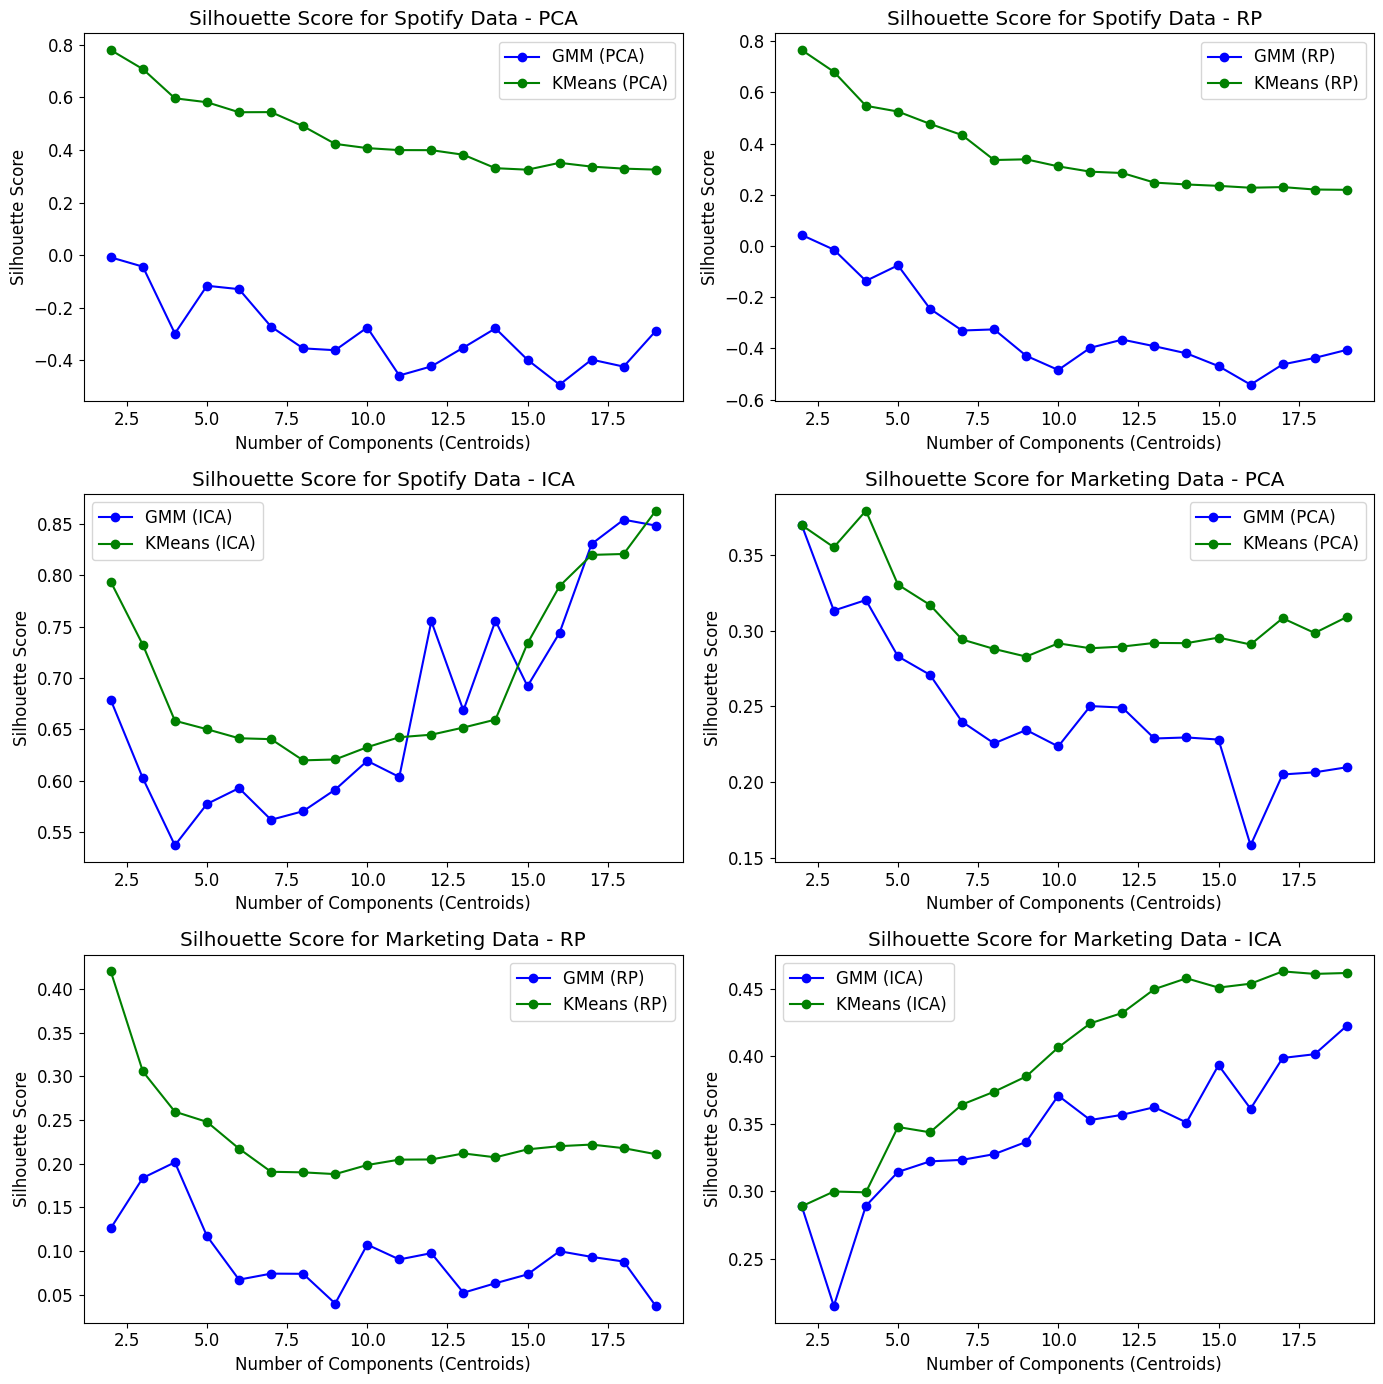

In [54]:
# Function to calculate Silhouette Scores for a range of n_components (for both GMM and KMeans)
def calculate_silhouette_scores_for_reduced_data(pipeline, X, n_components_range, model_type='gmm'):
    silhouette_scores = []
    
    for n_components in n_components_range:
        # Set the number of components for the GMM or KMeans
        if model_type == 'gmm':
            pipeline.named_steps['gmm'].n_components = n_components
        elif model_type == 'kmeans':
            pipeline.named_steps['kmeans'].n_clusters = n_components
        
        # Fit the pipeline
        pipeline.fit(X)
        
        labels = pipeline.predict(X)

   

        # Calculate silhouette score only if there are at least 2 clusters
        if len(np.unique(labels)) > 1:  # Ensure more than 1 cluster
            score = silhouette_score(X, labels)
        else:
            score = -1  # Assign a negative score if there's only 1 cluster
        silhouette_scores.append(score)
    
    return silhouette_scores

# Create a pipeline with GMM for the reduced data
pipeline_gmm_spotify_pca = Pipeline([
    ('gmm', GaussianMixture(init_params='k-means++', max_iter=200, n_init=10, random_state=42))
])

pipeline_gmm_spotify_rp = Pipeline([
    ('gmm', GaussianMixture(init_params='k-means++', max_iter=200, n_init=10, random_state=42))
])

pipeline_gmm_spotify_ica = Pipeline([
    ('gmm', GaussianMixture(init_params='k-means++', max_iter=200, n_init=10, random_state=42))
])

# Create a pipeline with KMeans for the reduced data
pipeline_kmeans_spotify_pca = Pipeline([
    ('kmeans', KMeans(init='k-means++', max_iter=200, n_init=50, random_state=42, algorithm="elkan"))
])

pipeline_kmeans_spotify_rp = Pipeline([
    ('kmeans', KMeans(init='k-means++', max_iter=200, n_init=50, random_state=42, algorithm="elkan"))
])

pipeline_kmeans_spotify_ica = Pipeline([
    ('kmeans', KMeans(init='k-means++', max_iter=200, n_init=50, random_state=42, algorithm="elkan"))
]) 
n_components_range = range(2, 20)

# Calculate Silhouette Scores for the dimension-reduced data (Spotify dataset )
print("Spotify")
silhouette_gmm_spotify_pca = calculate_silhouette_scores_for_reduced_data(pipeline_gmm_spotify_pca, transformed_pca_spotify, n_components_range, model_type='gmm')
silhouette_kmeans_spotify_pca = calculate_silhouette_scores_for_reduced_data(pipeline_kmeans_spotify_pca, transformed_pca_spotify, n_components_range, model_type='kmeans')

silhouette_gmm_spotify_rp = calculate_silhouette_scores_for_reduced_data(pipeline_gmm_spotify_rp, transformed_rp_spotify, n_components_range, model_type='gmm')
silhouette_kmeans_spotify_rp = calculate_silhouette_scores_for_reduced_data(pipeline_kmeans_spotify_rp, transformed_rp_spotify, n_components_range, model_type='kmeans')

silhouette_gmm_spotify_ica = calculate_silhouette_scores_for_reduced_data(pipeline_gmm_spotify_ica, transformed_ica_spotify, n_components_range, model_type='gmm')
silhouette_kmeans_spotify_ica = calculate_silhouette_scores_for_reduced_data(pipeline_kmeans_spotify_ica, transformed_ica_spotify, n_components_range, model_type='kmeans')
print("Spotify")
# Calculate Silhouette Scores for the dimension-reduced data (Marketing dataset)
silhouette_gmm_marketing_pca = calculate_silhouette_scores_for_reduced_data(pipeline_gmm_spotify_pca, transformed_pca_marketing, n_components_range, model_type='gmm')
silhouette_kmeans_marketing_pca = calculate_silhouette_scores_for_reduced_data(pipeline_kmeans_spotify_pca, transformed_pca_marketing, n_components_range, model_type='kmeans')

silhouette_gmm_marketing_rp = calculate_silhouette_scores_for_reduced_data(pipeline_gmm_spotify_rp, transformed_rp_marketing, n_components_range, model_type='gmm')
silhouette_kmeans_marketing_rp = calculate_silhouette_scores_for_reduced_data(pipeline_kmeans_spotify_rp, transformed_rp_marketing, n_components_range, model_type='kmeans')

silhouette_gmm_marketing_ica = calculate_silhouette_scores_for_reduced_data(pipeline_gmm_spotify_ica, transformed_ica_marketing, n_components_range, model_type='gmm')
silhouette_kmeans_marketing_ica = calculate_silhouette_scores_for_reduced_data(pipeline_kmeans_spotify_ica, transformed_ica_marketing, n_components_range, model_type='kmeans')

# Plot Silhouette Scores for both GMM and KMeans with different dimensionality reductions
plt.figure(figsize=(14, 14)) 

# Subplot 1: Spotify - Silhouette Scores for PCA, RP, and ICA for GMM and KMeans
plt.subplot(3, 2, 1)
plt.plot(n_components_range, silhouette_gmm_spotify_pca, marker='o', color='blue', label='GMM (PCA)')
plt.plot(n_components_range, silhouette_kmeans_spotify_pca, marker='o', color='green', label='KMeans (PCA)')
plt.xlabel('Number of Components (Centroids)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Spotify Data - PCA')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(n_components_range, silhouette_gmm_spotify_rp, marker='o', color='blue', label='GMM (RP)')
plt.plot(n_components_range, silhouette_kmeans_spotify_rp, marker='o', color='green', label='KMeans (RP)')
plt.xlabel('Number of Components (Centroids)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Spotify Data - RP')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(n_components_range, silhouette_gmm_spotify_ica, marker='o', color='blue', label='GMM (ICA)')
plt.plot(n_components_range, silhouette_kmeans_spotify_ica, marker='o', color='green', label='KMeans (ICA)')
plt.xlabel('Number of Components (Centroids)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Spotify Data - ICA')
plt.legend()

# Subplot 2: Marketing - Silhouette Scores for PCA, RP, and ICA for GMM and KMeans
plt.subplot(3, 2, 4)
plt.plot(n_components_range, silhouette_gmm_marketing_pca, marker='o', color='blue', label='GMM (PCA)')
plt.plot(n_components_range, silhouette_kmeans_marketing_pca, marker='o', color='green', label='KMeans (PCA)')
plt.xlabel('Number of Components (Centroids)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Marketing Data - PCA')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(n_components_range, silhouette_gmm_marketing_rp, marker='o', color='blue', label='GMM (RP)')
plt.plot(n_components_range, silhouette_kmeans_marketing_rp, marker='o', color='green', label='KMeans (RP)')
plt.xlabel('Number of Components (Centroids)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Marketing Data - RP')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(n_components_range, silhouette_gmm_marketing_ica, marker='o', color='blue', label='GMM (ICA)')
plt.plot(n_components_range, silhouette_kmeans_marketing_ica, marker='o', color='green', label='KMeans (ICA)')
plt.xlabel('Number of Components (Centroids)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Marketing Data - ICA')
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()




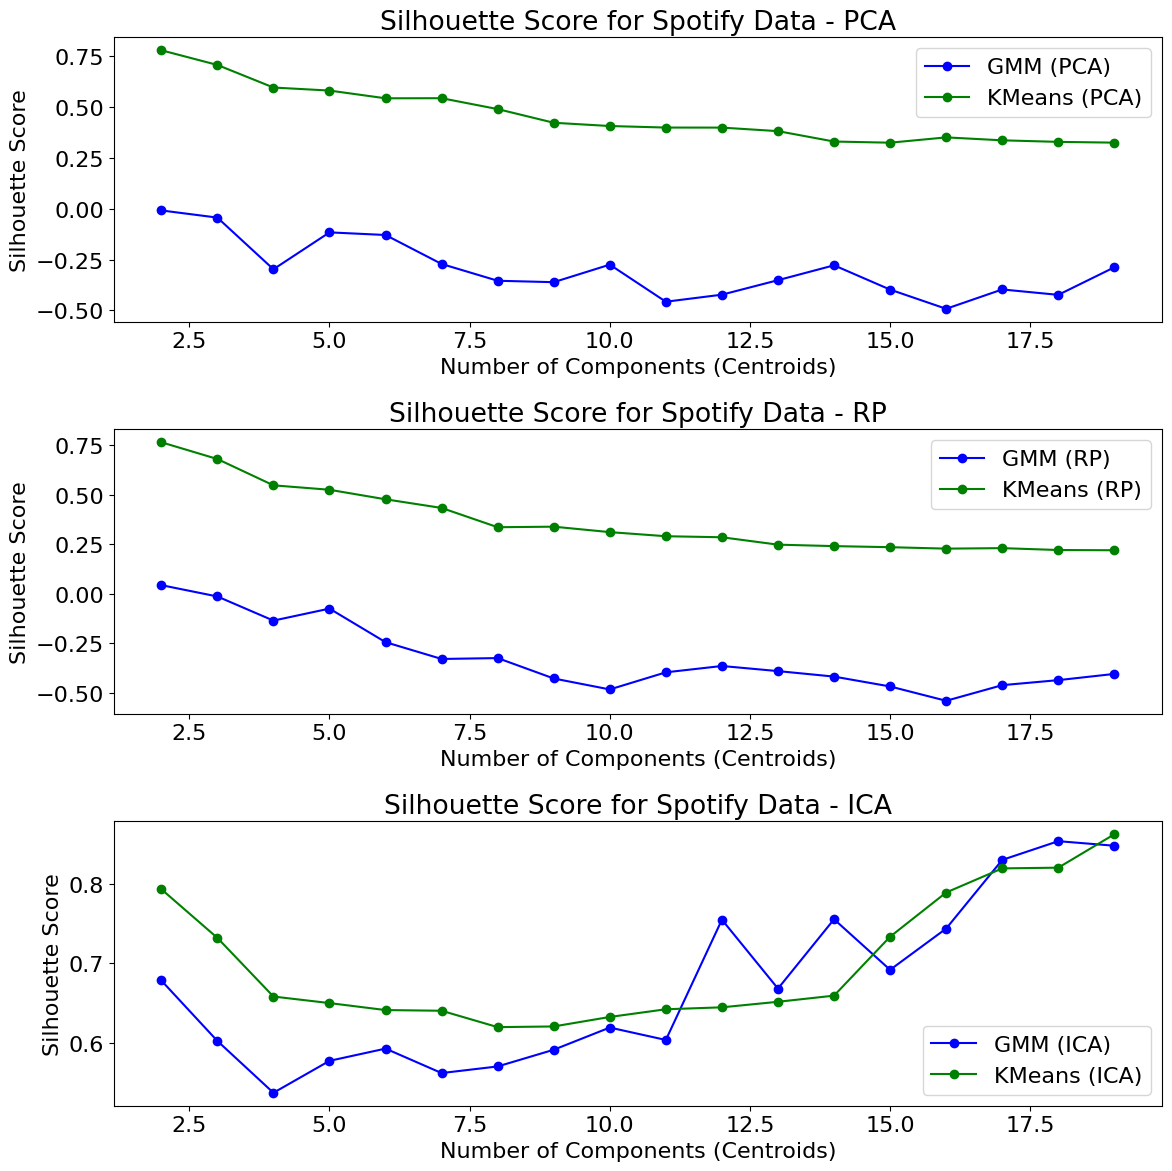

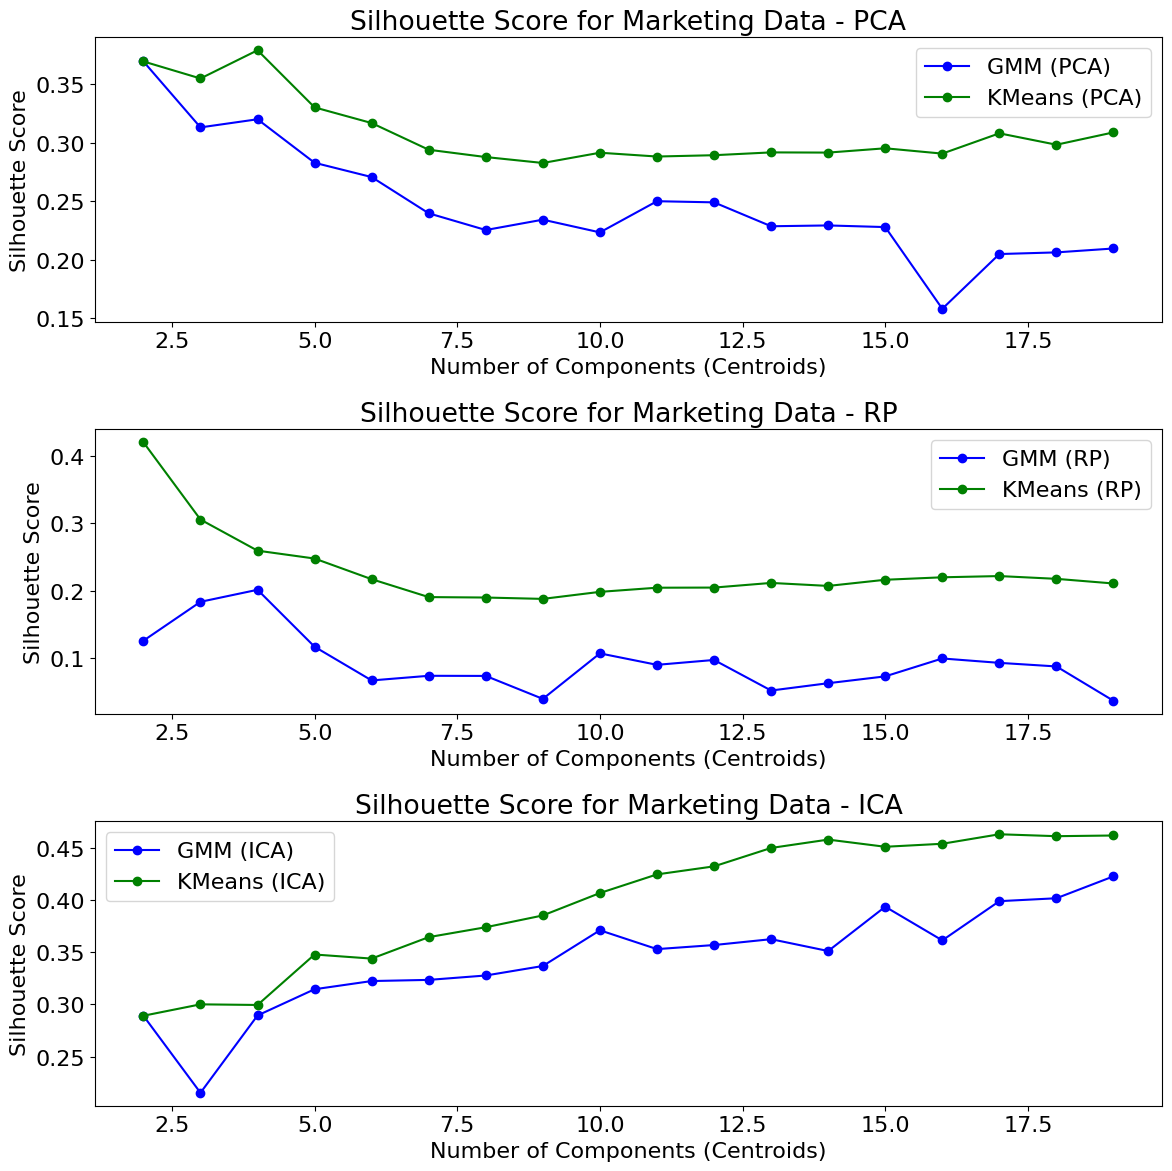

In [57]:


plt.rcParams.update({'font.size': 16})
# Set up the figure for two separate plots (Spotify and Marketing)
plt.figure(figsize=(12, 12))  # Adjust the figure size to fit two 3x1 grids

# Subplot 1: Spotify - Silhouette Scores for PCA, RP, and ICA for GMM and KMeans
plt.subplot(3, 1, 1)  
plt.plot(n_components_range, silhouette_gmm_spotify_pca, marker='o', color='blue', label='GMM (PCA)')
plt.plot(n_components_range, silhouette_kmeans_spotify_pca, marker='o', color='green', label='KMeans (PCA)')
plt.xlabel('Number of Components (Centroids)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Spotify Data - PCA')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(n_components_range, silhouette_gmm_spotify_rp, marker='o', color='blue', label='GMM (RP)')
plt.plot(n_components_range, silhouette_kmeans_spotify_rp, marker='o', color='green', label='KMeans (RP)')
plt.xlabel('Number of Components (Centroids)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Spotify Data - RP')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(n_components_range, silhouette_gmm_spotify_ica, marker='o', color='blue', label='GMM (ICA)')
plt.plot(n_components_range, silhouette_kmeans_spotify_ica, marker='o', color='green', label='KMeans (ICA)')
plt.xlabel('Number of Components (Centroids)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Spotify Data - ICA')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Subplot 2: Marketing - Silhouette Scores for PCA, RP, and ICA for GMM and KMeans
plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)  # Three rows, one column, this is the first plot (Marketing)
plt.plot(n_components_range, silhouette_gmm_marketing_pca, marker='o', color='blue', label='GMM (PCA)')
plt.plot(n_components_range, silhouette_kmeans_marketing_pca, marker='o', color='green', label='KMeans (PCA)')
plt.xlabel('Number of Components (Centroids)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Marketing Data - PCA')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(n_components_range, silhouette_gmm_marketing_rp, marker='o', color='blue', label='GMM (RP)')
plt.plot(n_components_range, silhouette_kmeans_marketing_rp, marker='o', color='green', label='KMeans (RP)')
plt.xlabel('Number of Components (Centroids)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Marketing Data - RP')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(n_components_range, silhouette_gmm_marketing_ica, marker='o', color='blue', label='GMM (ICA)')
plt.plot(n_components_range, silhouette_kmeans_marketing_ica, marker='o', color='green', label='KMeans (ICA)')
plt.xlabel('Number of Components (Centroids)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Marketing Data - ICA')
plt.legend()


plt.tight_layout()
plt.show()


In [ ]:
# Function to get top 3 optimal components based on silhouette score
def get_top_n_optimal_components(silhouette_scores, n=3):
    
    top_n_indices = np.argsort(silhouette_scores)[-n:][::-1]
    
    top_n_components = [n_components_range[i] for i in top_n_indices]
    top_n_scores = [silhouette_scores[i] for i in top_n_indices]
    
    return top_n_components, top_n_scores


top_3_gmm_spotify_pca, top_3_scores_gmm_spotify_pca = get_top_n_optimal_components(silhouette_gmm_spotify_pca, n=3)
top_3_kmeans_spotify_pca, top_3_scores_kmeans_spotify_pca = get_top_n_optimal_components(silhouette_kmeans_spotify_pca, n=3)


top_3_gmm_spotify_rp, top_3_scores_gmm_spotify_rp = get_top_n_optimal_components(silhouette_gmm_spotify_rp, n=3)
top_3_kmeans_spotify_rp, top_3_scores_kmeans_spotify_rp = get_top_n_optimal_components(silhouette_kmeans_spotify_rp, n=3)

top_3_gmm_spotify_ica, top_3_scores_gmm_spotify_ica = get_top_n_optimal_components(silhouette_gmm_spotify_ica, n=3)
top_3_kmeans_spotify_ica, top_3_scores_kmeans_spotify_ica = get_top_n_optimal_components(silhouette_kmeans_spotify_ica, n=3)


top_3_gmm_marketing_pca, top_3_scores_gmm_marketing_pca = get_top_n_optimal_components(silhouette_gmm_marketing_pca, n=3)
top_3_kmeans_marketing_pca, top_3_scores_kmeans_marketing_pca = get_top_n_optimal_components(silhouette_kmeans_marketing_pca, n=3)


top_3_gmm_marketing_rp, top_3_scores_gmm_marketing_rp = get_top_n_optimal_components(silhouette_gmm_marketing_rp, n=3)
top_3_kmeans_marketing_rp, top_3_scores_kmeans_marketing_rp = get_top_n_optimal_components(silhouette_kmeans_marketing_rp, n=3)


top_3_gmm_marketing_ica, top_3_scores_gmm_marketing_ica = get_top_n_optimal_components(silhouette_gmm_marketing_ica, n=3)
top_3_kmeans_marketing_ica, top_3_scores_kmeans_marketing_ica = get_top_n_optimal_components(silhouette_kmeans_marketing_ica, n=3)

# Print the top 3 optimal components for GMM and KMeans (Spotify and Marketing Data)
print("Top 3 Optimal Components for GMM on Spotify (PCA):", top_3_gmm_spotify_pca)
print("Top 3 Scores for GMM on Spotify (PCA):", top_3_scores_gmm_spotify_pca)

print("Top 3 Optimal Components for KMeans on Spotify (PCA):", top_3_kmeans_spotify_pca)
print("Top 3 Scores for KMeans on Spotify (PCA):", top_3_scores_kmeans_spotify_pca)

print("Top 3 Optimal Components for GMM on Spotify (RP):", top_3_gmm_spotify_rp)
print("Top 3 Scores for GMM on Spotify (RP):", top_3_scores_gmm_spotify_rp)

print("Top 3 Optimal Components for KMeans on Spotify (RP):", top_3_kmeans_spotify_rp)
print("Top 3 Scores for KMeans on Spotify (RP):", top_3_scores_kmeans_spotify_rp)

print("Top 3 Optimal Components for GMM on Spotify (ICA):", top_3_gmm_spotify_ica)
print("Top 3 Scores for GMM on Spotify (ICA):", top_3_scores_gmm_spotify_ica)

print("Top 3 Optimal Components for KMeans on Spotify (ICA):", top_3_kmeans_spotify_ica)
print("Top 3 Scores for KMeans on Spotify (ICA):", top_3_scores_kmeans_spotify_ica)

print("Top 3 Optimal Components for GMM on Marketing (PCA):", top_3_gmm_marketing_pca)
print("Top 3 Scores for GMM on Marketing (PCA):", top_3_scores_gmm_marketing_pca)

print("Top 3 Optimal Components for KMeans on Marketing (PCA):", top_3_kmeans_marketing_pca)
print("Top 3 Scores for KMeans on Marketing (PCA):", top_3_scores_kmeans_marketing_pca)

print("Top 3 Optimal Components for GMM on Marketing (RP):", top_3_gmm_marketing_rp)
print("Top 3 Scores for GMM on Marketing (RP):", top_3_scores_gmm_marketing_rp)

print("Top 3 Optimal Components for KMeans on Marketing (RP):", top_3_kmeans_marketing_rp)
print("Top 3 Scores for KMeans on Marketing (RP):", top_3_scores_kmeans_marketing_rp)

print("Top 3 Optimal Components for GMM on Marketing (ICA):", top_3_gmm_marketing_ica)
print("Top 3 Scores for GMM on Marketing (ICA):", top_3_scores_gmm_marketing_ica)

print("Top 3 Optimal Components for KMeans on Marketing (ICA):", top_3_kmeans_marketing_ica)
print("Top 3 Scores for KMeans on Marketing (ICA):", top_3_scores_kmeans_marketing_ica)


Top 3 Optimal Components for GMM on Spotify (PCA): [2, 3, 5]
Top 3 Scores for GMM on Spotify (PCA): [np.float64(-0.008089656348640877), np.float64(-0.04337458313596653), np.float64(-0.11603794357472356)]
Top 3 Optimal Components for KMeans on Spotify (PCA): [2, 3, 4]
Top 3 Scores for KMeans on Spotify (PCA): [np.float64(0.7798436179617767), np.float64(0.7075925596287439), np.float64(0.5965258921771897)]
Top 3 Optimal Components for GMM on Spotify (RP): [2, 3, 5]
Top 3 Scores for GMM on Spotify (RP): [np.float64(0.043198845995390395), np.float64(-0.014095246817405772), np.float64(-0.07536133188629322)]
Top 3 Optimal Components for KMeans on Spotify (RP): [2, 3, 4]
Top 3 Scores for KMeans on Spotify (RP): [np.float64(0.7652182876286239), np.float64(0.6805196529417242), np.float64(0.5475874362425053)]
Top 3 Optimal Components for GMM on Spotify (ICA): [18, 19, 17]
Top 3 Scores for GMM on Spotify (ICA): [np.float64(0.8538942692864838), np.float64(0.8481626160458238), np.float64(0.830317875

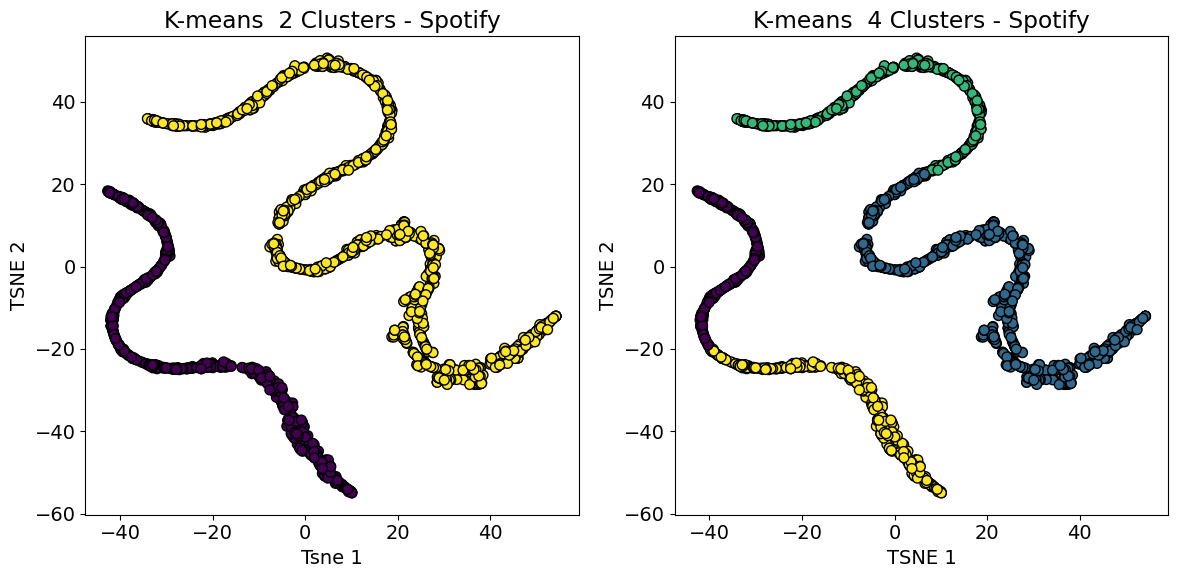

In [ ]:
plt.rcParams.update({'font.size': 14})  


# Updated pipeline with PCA step (ignore names come from other part of code
pipeline_kmeans_marketing_dim_2= Pipeline([
    ('preprocessor', preprocessor_marketing),  
    ('pca', PCA(n_components=8, random_state=42)),
    ('mm',KMeans(n_clusters=2, init='k-means++', max_iter=200, n_init=50, random_state=42, algorithm="elkan"))  
])

pipeline_kmeans_marketing_dim_4 = Pipeline([
    ('preprocessor', preprocessor_marketing),  
    ('pca', PCA(n_components=8, random_state=42)),
    ('kmeans', KMeans(n_clusters=4, init='k-means++', max_iter=200, n_init=50, random_state=42, algorithm="elkan"))  
])

# Fit the models
pipeline_kmeans_marketing_dim_2.fit(x_marketing) 
labels_kmeans_2 = pipeline_kmeans_marketing_dim_2.predict(x_marketing)

pipeline_kmeans_marketing_dim_4.fit(x_marketing) 
labels_kmeans4 = pipeline_kmeans_marketing_dim_4.predict(x_marketing)


pca = PCA(n_components=2, random_state=42)
x_mark_pre = preprocessor_marketing.fit_transform(x_marketing)
x_ica = pca.fit_transform(x_mark_pre)


tsne = TSNE(n_components=2, random_state=42)
x_tsne = tsne.fit_transform(x_ica)

# Step 3: Plot the clusters for K-means and GMM
plt.figure(figsize=(12, 6))

# K-means Clustering Plot
plt.subplot(1, 2, 1)
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=labels_kmeans_2, cmap='viridis', edgecolor='k', s=50)
plt.title('K-means  2 Clusters - Spotify')
plt.xlabel('Tsne 1')
plt.ylabel('TSNE 2')

# GMM Clustering Plot
plt.subplot(1, 2, 2)
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=labels_kmeans4, cmap='viridis', edgecolor='k', s=50)
plt.title('K-means  4 Clusters - Spotify')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')

# Show the plots
plt.tight_layout()
plt.show()




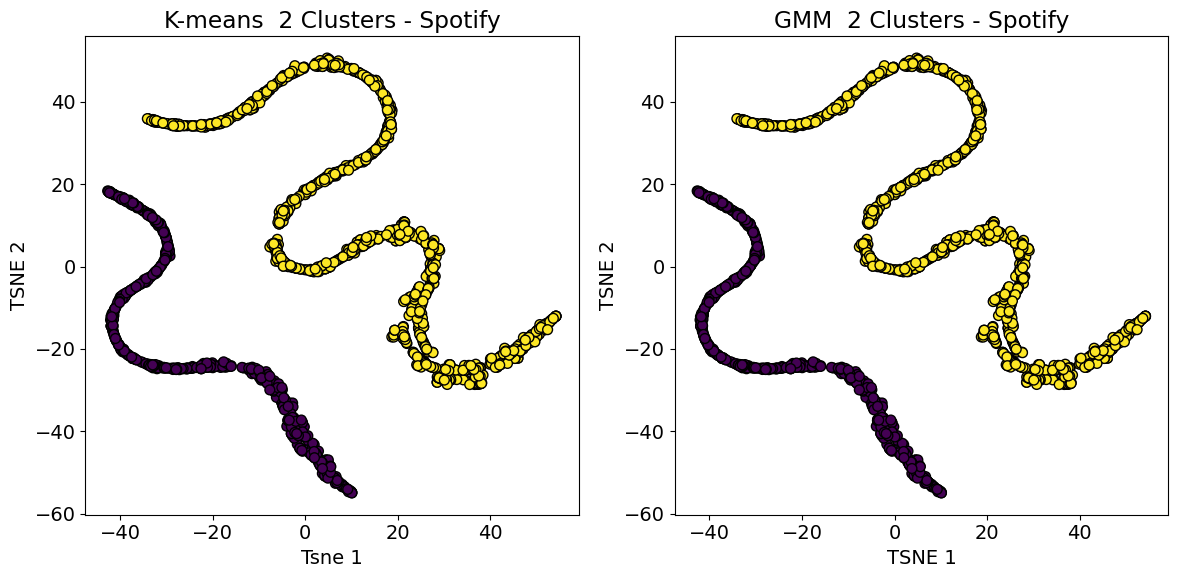

In [61]:
plt.rcParams.update({'font.size': 14})  


# Updated pipeline with PCA step (ignore names come from other part of code
pipeline_kmeans_marketing_dim_2= Pipeline([
    ('preprocessor', preprocessor_marketing),  
    ('pca', PCA(n_components=8, random_state=42)),
    ('mm',KMeans(n_clusters=2, init='k-means++', max_iter=200, n_init=50, random_state=42, algorithm="elkan"))  
])

pipeline_kmeans_marketing_dim_4 = Pipeline([
    ('preprocessor', preprocessor_marketing),  
    ('pca', PCA(n_components=8, random_state=42)),
    ('kmeans', GaussianMixture(n_components=2,init_params='k-means++', max_iter=200, n_init=10, random_state=42))  
])

# Fit the models
pipeline_kmeans_marketing_dim_2.fit(x_marketing) 
labels_kmeans_2 = pipeline_kmeans_marketing_dim_2.predict(x_marketing)

pipeline_kmeans_marketing_dim_4.fit(x_marketing) 
labels_kmeans4 = pipeline_kmeans_marketing_dim_4.predict(x_marketing)


pca = PCA(n_components=2, random_state=42)
x_mark_pre = preprocessor_marketing.fit_transform(x_marketing)
x_ica = pca.fit_transform(x_mark_pre)


tsne = TSNE(n_components=2, random_state=42)
x_tsne = tsne.fit_transform(x_ica)

# Step 3: Plot the clusters for K-means and GMM
plt.figure(figsize=(12, 6))

# K-means Clustering Plot
plt.subplot(1, 2, 1)
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=labels_kmeans_2, cmap='viridis', edgecolor='k', s=50)
plt.title('K-means  2 Clusters - Spotify')
plt.xlabel('Tsne 1')
plt.ylabel('TSNE 2')

# GMM Clustering Plot
plt.subplot(1, 2, 2)
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=labels_kmeans4, cmap='viridis', edgecolor='k', s=50)
plt.title('GMM  2 Clusters - Spotify')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')

# Show the plots
plt.tight_layout()
plt.show()


